In [1]:
import torch, numpy as np, pandas as pd
import sklearn as sk
from datetime import datetime
from torch import nn
from torch.utils.data import DataLoader, Dataset
from scipy.ndimage.measurements import center_of_mass
from sklearn.model_selection import train_test_split

<ipython-input-1-fe302d509ea6>:6: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import center_of_mass


In [2]:
!mkdir attempt1

mkdir: cannot create directory ‘attempt1’: File exists


## Data Preparation ##

In [3]:
INPUT_PATH = 'https://cernbox.cern.ch/remote.php/dav/public-files/dbwReGGBIPARvqM/converted_all.csv'
layers = [0]
cell_sizes_cm = [1.515, 3.03, 4.04, 6.06, 12.12]
#cell_sizes_cm = [1.515]

In [4]:
def get_time_cell_3x3(row):
    time = row[:9]
    energy = row[9:]
    return (time * energy).sum() / (energy.sum() + 1e-6)


def get_time_cell_5x5(row):
    time = row[:25]
    energy = row[25:]
    return (time * energy).sum() / (energy.sum() + 1e-6)


def get_features(df):
    df['xGen_pred'] = 0.0
    df['yGen_pred'] = 0.0
    df['p_pred'] = 0.0
    df['t_pred'] = 0.0

    for layer in layers:
        df['l{}_sum_3x3'.format(layer)] = \
            df[['l{}_{}'.format(layer, i) for i in [6,7,8,
                                                    11,12,13,
                                                    16,17,18]]].values.sum(axis=1)

        df['l{}_sum_5x5'.format(layer)] = \
            df[['l{}_{}'.format(layer, i) for i in range(25)]].values.sum(axis=1)


    df['z_ref'] = np.zeros_like(df['entry_x'].values)
    df.loc[df['cell_size'] == 1.515, 'z_ref'] = 7.0
    df.loc[df['cell_size'] == 3.03, 'z_ref'] = 10.0
    df.loc[df['cell_size'] == 4.04, 'z_ref'] = 17.0
    df.loc[df['cell_size'] == 6.06, 'z_ref'] = 17.0
    df.loc[df['cell_size'] == 12.12, 'z_ref'] = 0.0
    
    barycenter = np.apply_along_axis(get_center_cluster, axis=1,
                                     arr = df[['cell_size'] + \
                                              ['l{}_{}'.format(0, i) for i in range(25)]].values)       
        
    for i, axis in enumerate(['x','y']):
        df['l0_{}_bar'.format(axis)] = \
            barycenter[:,i] + \
            df['{}_seed_shift'.format(axis)].values * df['cell_size'].values

        df['entry_{}_new'.format(axis)] = \
            (df['entry_{}'.format(axis)].values*0.1 + \
             df['z_ref'].values * (df['p{}'.format(axis)].values / df['pz'].values)) * 10

### angle
        df['l0_{}_bar_cal'.format(axis)] = \
            np.floor(df['entry_{}'.format(axis)].values * 0.1 / df['cell_size'].values) * \
            df['cell_size'].values + 0.5 * df['cell_size'].values + \
            df['l0_{}_bar'.format(axis)]

        df['l0_{}Rec_loc'.format(axis)] = \
            df['l0_{}_bar_cal'.format(axis)].values - \
            (np.floor(df['l0_{}_bar_cal'.format(axis)].values / df['cell_size'].values) * \
             df['cell_size'].values + 0.5 * df['cell_size'].values)

        df['l0_{}Gen_loc'.format(axis)] = \
            df['entry_{}_new'.format(axis)].values*0.1 - \
            (np.floor(df['l0_{}_bar_cal'.format(axis)].values / df['cell_size'].values) * \
             df['cell_size'].values + 0.5 * df['cell_size'].values)
    
    for layer in layers:
        df['t{}_weighted_3x3'.format(layer)] = np.apply_along_axis(get_time_cell_3x3, 
                                                    axis=1, 
                                                    arr=df[['t{}_{}'.format(layer,c) for c in [6,7,8,11,12,13,16,17,18]] + \
                                                           ['l{}_{}'.format(layer,c) for c in [6,7,8,11,12,13,16,17,18]]].values)

        df['t{}_weighted_5x5'.format(layer)] = np.apply_along_axis(get_time_cell_5x5, 
                                                    axis=1, 
                                                    arr=df[['t{}_{}'.format(layer,c) for c in range(25)] + \
                                                           ['l{}_{}'.format(layer,c) for c in range(25)]].values)

In [5]:
def get_center_cluster(row):
    return (np.array(center_of_mass(row[1:].reshape(5,5))) - 2.0) * row[0]


def get_rmse(x, y):
    return np.nanmean(((x - y) ** 2.0)) ** 0.5


def get_rmse_metric(x, y, folds=5):
    if x.shape != y.shape:
        print('x.shape != y.shape')
        raise

    splits = np.array_split(np.arange(len(x)), folds)

    rmse = []
    for split in splits:
        rmse.append(get_rmse(x[split], y[split]))

    return np.nanmean(rmse), np.nanstd(rmse)

In [6]:
def calib(df):
    cell_sizes = [1.515, 3.03, 4.04, 6.06, 12.12]

    A = dict()
    B = dict()

    A[0] = dict()
    B[0] = dict()
    A[0][1.515] = 0.00497
    B[0][1.515] = 109.5
    A[0][3.03] = 0.09641
    B[0][3.03] = 23.4
    A[0][4.04] = 0.2382
    B[0][4.04] = 70.72
    A[0][6.06] = 0.2401
    B[0][6.06] = 75.22
    A[0][12.12] = 0.2458
    B[0][12.12] = 57.76

    for layer in layers:
        for cell_size in cell_sizes:
            for cell_num in range(25):
                e_calib = df.loc[df.cell_size == cell_size, 'l{}_{}'.format(layer, cell_num)] * A[layer][cell_size] + \
                        B[layer][cell_size]
                df.loc[df.cell_size == cell_size, 'l{}_{}'.format(layer, cell_num)] = \
                    np.clip(e_calib, a_min=0, a_max=None)

    return df

In [7]:
nPV_start_time = datetime.now()
data_train = pd.read_csv(INPUT_PATH)#[:N_SIGNALS]

data_train = data_train[~np.isnan(data_train.l0_12.values)].reset_index(drop=True)

data_train = calib(data_train)

data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
data_train.fillna(0, inplace=True)

data_train['p_ECAL'] = data_train['eKinetic'].values * 1000
data_train['t_ECAL'] = data_train.timing.values

data_train['x_ECAL'] = data_train.entry_x.values
data_train['y_ECAL'] = data_train.entry_y.values
data_train['z_ECAL'] = data_train.entry_z.values

#data_train = data_train[data_train['p_ECAL'] < 20000]

In [8]:
for layer in layers:
    data_train['l{}_sum_5x5_rec'.format(layer)] = 0.0

    for cell_size in cell_sizes_cm:
        sum_of_cluster = data_train[data_train.cell_size == cell_size][['l{}_{}'.format(layer, i) for i in range(25)]].values.sum(axis=-1)
        corr_coef = np.nanmean((data_train[data_train.cell_size == cell_size].p_ECAL.values)) / np.nanmean(sum_of_cluster)
        data_train.loc[data_train.cell_size == cell_size, 'l{}_sum_5x5_rec'.format(layer)] = sum_of_cluster * corr_coef

get_features(data_train)

data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
data_train.fillna(0, inplace=True)

In [9]:
!nvidia-smi

Mon May 29 17:22:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
class MyDataset(Dataset):
 
  def __init__(self,X,y):
    self.X = torch.tensor(np.array(X[:,:25]).reshape(len(X),1,5,5),dtype=torch.float32)
    self.feat = torch.tensor(np.array(X[:,25:]),dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
 
  def __len__(self):
    return len(self.y)
   
  def __getitem__(self,idx):
    return self.X[idx],self.feat[idx], self.y[idx]

In [11]:
train_features = []

for layer in layers:
      train_features += \
            ['l{}_{}'.format(layer, i) for i in range(25)]+ \
            ['l{}_sum_5x5_rec'.format(layer)] + \
             ['l{}_sum_3x3'.format(layer)] + \
             ['l{}_sum_5x5'.format(layer)]


In [12]:
cell_size = cell_sizes_cm[3]

In [13]:
data = data_train[data_train['cell_size'] == cell_size][train_features]
target = data_train[data_train['cell_size'] == cell_size]['p_ECAL'].values
data['target'] = target

In [14]:
import numpy as np

def remove_outliers(data, threshold=3):
    """
    Removes outliers from the given data using the z-score method.
    
    Args:
        data (ndarray): Input data array.
        threshold (float): Z-score threshold for outlier detection.
    
    Returns:
        ndarray: Data array with outliers removed.
    """
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    filtered_data = data[z_scores < threshold]
    
    return filtered_data


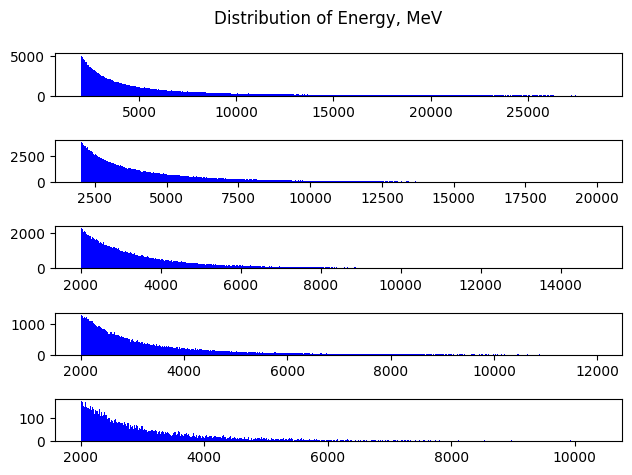

In [15]:
import matplotlib.pyplot as plt
cell_sizes = [1.515, 3.03, 4.04, 6.06, 12.12]
fig, axs = plt.subplots(5)
fig.suptitle('Distribution of Energy, MeV')
fig.tight_layout()
axs[0].hist(remove_outliers(data_train[data_train['cell_size'] == cell_sizes[0]]['p_ECAL'].values), bins = 500,color='blue')
axs[1].hist(remove_outliers(data_train[data_train['cell_size'] == cell_sizes[1]]['p_ECAL'].values), bins = 500,color='blue')
axs[2].hist(remove_outliers(data_train[data_train['cell_size'] == cell_sizes[2]]['p_ECAL'].values), bins = 500, color='blue')
axs[3].hist(remove_outliers(data_train[data_train['cell_size'] == cell_sizes[3]]['p_ECAL'].values), bins = 500, color='blue')
axs[4].hist(remove_outliers(data_train[data_train['cell_size'] == cell_sizes[4]]['p_ECAL'].values), bins = 500, color='blue')

fig.show()

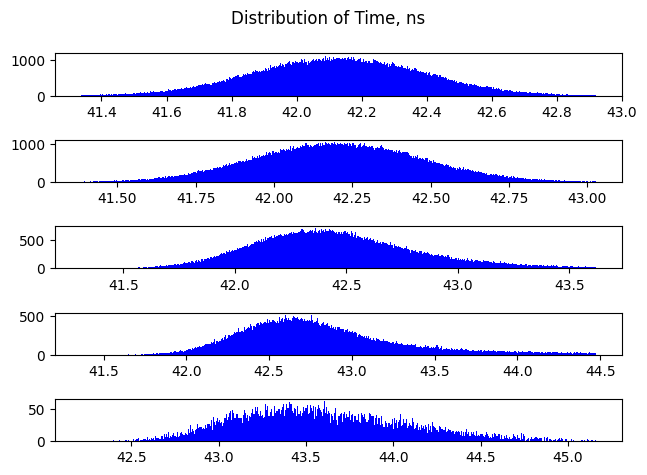

In [16]:
import matplotlib.pyplot as plt
cell_sizes = [1.515, 3.03, 4.04, 6.06, 12.12]
fig, axs = plt.subplots(5)
fig.suptitle('Distribution of Time, ns')
fig.tight_layout()
axs[0].hist(remove_outliers(data_train[data_train['cell_size'] == cell_sizes[0]]['t_ECAL'].values), bins = 500,color='blue')
axs[1].hist(remove_outliers(data_train[data_train['cell_size'] == cell_sizes[1]]['t_ECAL'].values), bins = 500,color='blue')
axs[2].hist(remove_outliers(data_train[data_train['cell_size'] == cell_sizes[2]]['t_ECAL'].values), bins = 500, color='blue')
axs[3].hist(remove_outliers(data_train[data_train['cell_size'] == cell_sizes[3]]['t_ECAL'].values), bins = 500, color='blue')
axs[4].hist(remove_outliers(data_train[data_train['cell_size'] == cell_sizes[4]]['t_ECAL'].values), bins = 500, color='blue')

fig.show()

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 [Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5')])

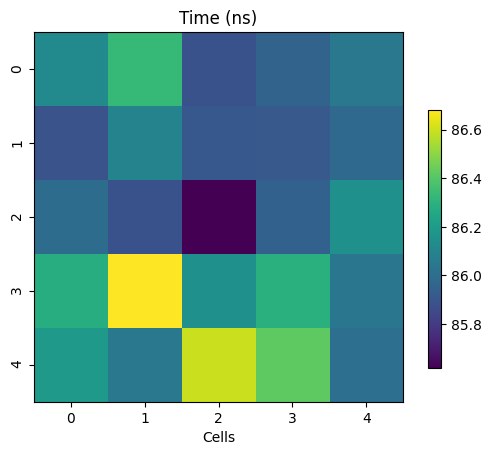

In [17]:
im = plt.imshow(data_train[['t{}_{}'.format(0,i) for i in range(25)]].iloc[2].values.reshape(5,5), label = 'Energy')
plt.colorbar(im, location='right', anchor=(0, 0.3), shrink=0.7)
plt.xlabel('Cells')
plt.title('Time (ns)')
plt.xlabel('Cells')
plt.yticks(rotation=90)

Text(0.5, 0, 'Cells')

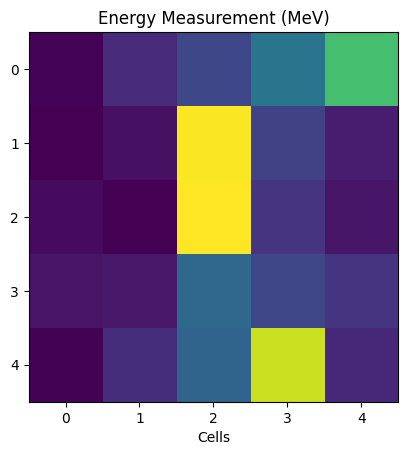

In [18]:
xim = plt.imshow(data.iloc[0][:25].values.reshape(5,5), label = 'Energy')
plt.colorbar(im, location='right', anchor=(0, 0.3), shrink=0.7)
plt.xlabel('Cells')
plt.title('Energy Measurement (MeV)')
plt.xlabel('Cells')

## Modelling ##

In [19]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn

def conv_block(input_size, output_size, kernel_size):
    block = nn.Sequential(
        nn.Conv2d(input_size, output_size, kernel_size, bias= False), nn.LeakyReLU(0.15), nn.BatchNorm2d(output_size), nn.Dropout(0.2),
    )

    return block

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_block1 = conv_block(1,128,(3,3))
        self.conv_block2 = conv_block(128,256,(3,3))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(259, 512)
        self.relu1 = nn.LeakyReLU(0.25)
        self.linear2 = nn.Linear(512, 64)
        self.relu2 = nn.LeakyReLU(0.1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(64)
        self.linear3 = nn.Linear(64, 1)
        self.drop = nn.Dropout(0.35)
        
    def forward(self, x, feat):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.flatten(x)
        x = torch.hstack((x,feat))
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        #x = self.drop(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.drop(x)
        x = self.linear3(x)
        return self.relu2(x)


def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

cnn = CNN()
cnn.apply(init_weights)



CNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.15)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.15)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=259, out_features=512, bias=True)
  (relu1): LeakyReLU(negative_slope=0.25)
  (linear2): Linear(in_features=512, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.1)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linea

In [20]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        
        self.linear1 = nn.Linear(25,32)
        self.linear2 = nn.Linear(35,16)
        self.linear3 = nn.Linear(16,1)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(16)
        self.flatten = nn.Flatten()

        
    def forward(self, x, feat):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = torch.hstack((x,feat))
        x = self.linear2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.linear3(x)
        return x

In [21]:
data_train[data_train['cell_size'] == cell_size]

,runNumber,evtNumber,evtIndex,prod_vertex_x,prod_vertex_y,prod_vertex_z,entry_x,entry_y,entry_z,px,...,l0_x_bar_cal,l0_xRec_loc,l0_xGen_loc,l0_y_bar,entry_y_new,l0_y_bar_cal,l0_yRec_loc,l0_yGen_loc,t0_weighted_3x3,t0_weighted_5x5
18,666,6051,0,17.378469,-25.509145,2974.182733,-2067.475154,-858.986398,12620.0,-509.312455,...,-209.333539,-0.263539,-1.351907,2.440551,-873.675784,-85.429449,2.440551,0.502422,-7.109459e+36,-8.928443e+36
21,666,6051,0,-13.304956,22.071858,2560.496458,878.613551,-1830.029757,12620.0,188.492727,...,88.499686,0.629686,1.498648,0.671764,-1861.329242,-184.158236,0.671764,-1.302924,-2.986315e+37,-3.645696e+37
52,666,6051,0,0.018357,-0.007870,53.853277,-1332.634861,1773.747611,12620.0,-221.565792,...,-137.983058,-1.633058,1.283646,1.170342,1797.743705,179.940342,1.170342,1.004370,-1.828698e+37,-2.544535e+37
74,666,6051,0,4.340043,-8.177576,275.553736,-3646.847686,314.714016,12620.0,-665.443801,...,-365.830783,0.799217,-3.082956,-4.042856,319.160677,29.287144,2.017144,4.646068,-1.497519e+37,-1.956731e+37
79,666,6051,0,-0.044057,0.003320,6.230175,-2377.307852,1349.389633,12620.0,-868.098251,...,-241.345755,-1.975755,-1.564703,-1.683262,1367.575764,134.666738,-1.683262,0.407576,-1.662730e+37,-2.169635e+37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642515,666,7250,999,-0.036751,-0.017263,-32.400318,1064.108254,-1237.521211,12620.0,198.997700,...,106.347298,0.297298,1.790630,0.442624,-1254.148543,-123.787376,0.442624,-1.184854,-2.219559e+37,-2.157556e+37
642519,666,7250,999,-0.036751,-0.017263,-32.400318,-474.923881,1353.510502,12620.0,-80.413733,...,-40.589721,-1.199721,-8.740455,-3.098565,1371.696752,133.251435,2.961435,6.879675,-1.390551e+37,-2.179379e+37
642520,666,7250,999,-0.036751,-0.017263,-32.400318,101.284161,-1343.789093,12620.0,43.584055,...,9.334527,0.244527,1.174553,-0.396165,-1361.844261,-136.746165,-0.396165,0.165574,-7.628201e+36,-1.793394e+37
642540,666,7250,999,1404.531418,-272.697249,9241.592070,2700.050127,-364.572881,12620.0,805.433071,...,273.051547,-2.678453,0.794006,4.086237,-369.196022,-35.303763,-1.973763,-3.589602,-4.730127e+36,-8.174299e+36


In [22]:
X_train,X_val,y_train,y_val = train_test_split(data,data.target, random_state=42, shuffle=True)
# y_train = np.log1p(y_train)
# y_val = np.log1p(y_val)
from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# t_c = X_train.columns
# X_train = scaler.fit_transform(X_train)
# X_train =` pd.DataFrame(X_train, columns=t_c)

# v_c = X_val.columns
# X_val = scaler.transform(X_val)
# X_val = pd.DataFrame(X_val, columns=v_c)


In [23]:
#X_train['target'] = y_train

In [24]:
# from sklearn.utils.class_weight import compute_sample_weight
# from imblearn.over_sampling import RandomOverSampler
# from sklearn.metrics import mean_squared_error
# rus = RandomOverSampler(random_state=0)

# hist, bin_edges = np.histogram(y_train, bins = 20)
# classes = pd.DataFrame(y_train).apply(lambda x: pd.cut(x, bin_edges, labels = False, 
#                                                    include_lowest = True)).values

# sample_weights = compute_sample_weight('balanced', classes)
# t_c = X_train.columns
# X_train_resampled, classes_resam = rus.fit_resample(X_train, classes)
# X_train_resampled = pd.DataFrame(X_train_resampled, columns=t_c)

In [25]:
X_train = X_train.drop('target',axis=1)
X_val = X_val.drop('target',axis=1)
#y_train = X_train_resampled['target']

(array([8.760e+03, 4.103e+03, 2.187e+03, 1.239e+03, 7.710e+02, 4.780e+02,
        3.570e+02, 2.450e+02, 1.790e+02, 1.330e+02, 1.060e+02, 7.000e+01,
        6.700e+01, 5.200e+01, 3.400e+01, 2.900e+01, 1.700e+01, 2.600e+01,
        1.400e+01, 1.700e+01, 2.100e+01, 1.100e+01, 7.000e+00, 6.000e+00,
        7.000e+00, 3.000e+00, 7.000e+00, 3.000e+00, 7.000e+00, 8.000e+00,
        0.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+0

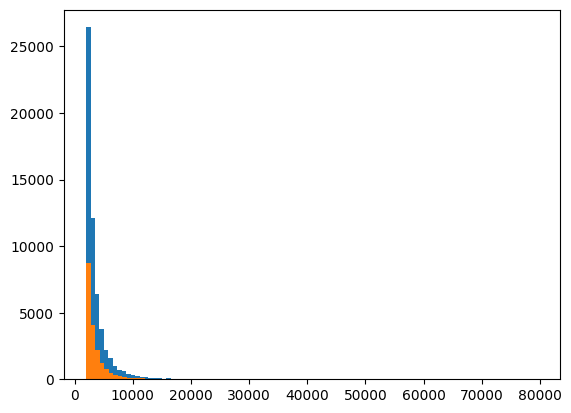

In [26]:
import matplotlib.pyplot as plt

plt.hist(y_train,bins=100)
plt.hist(y_val,bins=100)

In [27]:
len(X_train)

57036

In [28]:
X_train.shape

(57036, 28)

In [29]:
# X_train_resampled,_,y_train_resampled,_ = train_test_split(data_resampled.drop('target',axis=1),data_resampled.target, random_state=42, shuffle=True)
# X_train_resampled,  y_train_resampled = X_train_resampled.drop('target',axis=1), X_train_resampled['target']
# #_,X_val,_,y_val = train_test_split(data.drop('target',axis=1),data.target, random_state=42, shuffle=True)


In [30]:
#X_train_resampled

(array([1.2863e+04, 3.4260e+03, 1.2490e+03, 6.0200e+02, 3.1200e+02,
        1.7600e+02, 1.1900e+02, 6.3000e+01, 4.3000e+01, 3.1000e+01,
        3.2000e+01, 1.3000e+01, 1.0000e+01, 1.0000e+01, 1.5000e+01,
        3.0000e+00, 5.0000e+00, 3.0000e+00, 6.0000e+00, 6.0000e+00,
        2.0000e+00, 4.0000e+00, 6.0000e+00, 0.0000e+00, 0.0000e+00,
        3.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 2000.05819848,  3550.25218861,  5100.44617873,  6650.64016886,
         8200.83415899,  9751.02814912, 11301.22213925, 12851.41612937,
        14401.6101195 , 15951.80410963, 17501.99809976, 19052.19208989,
        20602.38608001, 22152.58007014, 23702.77406027, 25252.9680504 ,
        26803.16204053, 28353.

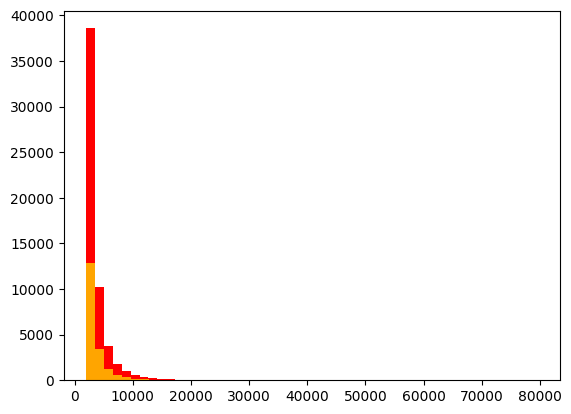

In [31]:
import matplotlib.pyplot as plt
plt.hist(y_train, color = 'red',bins=50)
plt.hist(y_val, color = 'orange',bins=50)

In [32]:
train_set = MyDataset(X_train.values, y_train.values)
val_set = MyDataset(X_val.values, y_val.values)

training_loader = DataLoader(train_set, batch_size = 2048,)# sampler = wrs)
validation_loader = DataLoader(val_set, batch_size = 2048)

In [33]:
def early_stopping(val_loss, patiance = 5):
  counter = 0.
  for v in range(patiance):
    if val_loss[-v] > val_loss[-v-1]:
      counter += 1.
    else:
      False

  if patiance == counter:
    return True


In [34]:
train_losses = []
val_losses = [] 

def train_regression_model(model, criterion,  val_crit, optimizer, train_loader, val_loader, num_epochs, patiance = 5):
    # set up the device to use for training
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_model = 0.
    best_validation = float('inf')

    # train the model
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, feats, labels = data

            # move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)
            feats = feats.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs,feats).squeeze()
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            #running_loss += mean_squared_error(sctarg.inverse_transform(outputs.cpu().detach().numpy().reshape(-1, 1)), sctarg.inverse_transform(labels.cpu().detach().numpy().reshape(-1, 1))).item() 

       
        epoch_loss = np.sqrt(running_loss / len(train_loader))  # calculate the average epoch loss
        running_loss = 0
        train_losses.append(epoch_loss)
        print(f"Average training loss for epoch {epoch+1}: {epoch_loss:.5f}")

        running_val_loss = 0.0

        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                inputs, feats, labels = data

                # move the inputs and labels to the device
                inputs = inputs.to(device)
                labels = labels.to(device)
                feats = feats.to(device)

                # forward pass
                outputs = model(inputs,feats).squeeze()
                loss = val_crit(outputs, labels.squeeze())

                # accumulate validation loss
                #running_val_loss += mean_squared_error(sctarg.inverse_transform(outputs.cpu().detach().numpy().reshape(-1, 1)), 
                #                              sctarg.inverse_transform(labels.cpu().detach().numpy().reshape(-1, 1))).item() 
                running_val_loss += loss.item()
        val_loss = np.sqrt(running_val_loss / len(val_loader))
        if val_loss < best_validation:
          best_model = model
          best_validation = val_loss

        val_losses.append(val_loss)
        print(f"Average validation loss for epoch {epoch+1}: {val_loss:.5f}")
       
        if epoch > patiance:
          if early_stopping(val_losses,patiance):
            print('Early stopping')
            break
      
    torch.save(model.state_dict(), '/content/attempt1/epoch'+str(epoch))
    return best_model
    print('Finished Training')


In [35]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(actual + 1), torch.log(pred + 1)))

In [36]:
class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.where(actual > 18000, 30000.0*self.mse(pred,actual), self.mse(pred,actual)).mean()

(array([1.5549e+04, 2.2420e+03, 6.6100e+02, 2.6200e+02, 1.0600e+02,
        6.4000e+01, 4.3000e+01, 1.8000e+01, 1.9000e+01, 6.0000e+00,
        8.0000e+00, 9.0000e+00, 6.0000e+00, 6.0000e+00, 0.0000e+00,
        4.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 2000.05819848,  4583.71484869,  7167.3714989 ,  9751.02814912,
        12334.68479933, 14918.34144954, 17501.99809976, 20085.65474997,
        22669.31140018, 25252.9680504 , 27836.62470061, 30420.28135082,
        33003.93800104, 35587.59465125, 38171.25130146, 40754.90795168,
        43338.56460189, 45922.2212521 , 48505.87790232, 51089.53455253,
        53673.19120274, 56256.84785296, 58840.50450317, 61424.16115339,
        64007.8178036 , 66591.47445381, 69175.13110403, 71758.78775424,
        74342.44440445, 76926.10105467, 79509.75770488]),
 <BarContainer object of 30 

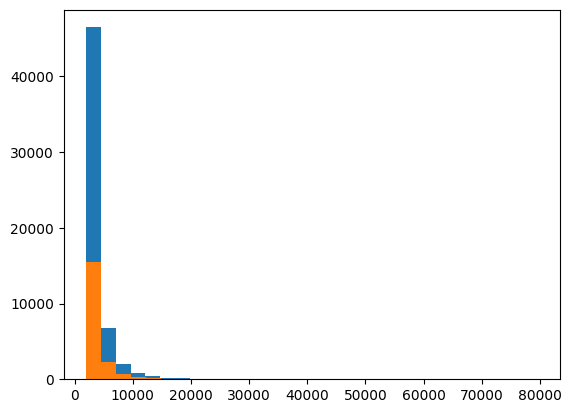

In [37]:
plt.hist(y_train, bins=30)
plt.hist(y_val, bins=30)

In [38]:
#loss_fn = RMSLELoss()
#loss_fn = my_loss
val_loss = torch.nn.MSELoss()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.1)#,weight_decay = 0.000001)
cnn.apply(init_weights)

train_losses = []
val_losses = [] 

In [39]:
best_model = train_regression_model(cnn, loss_fn, val_loss, optimizer, training_loader, validation_loader, num_epochs=15, patiance = 4)

Average training loss for epoch 1: 4411.80536
Average validation loss for epoch 1: 4168.96446
Average training loss for epoch 2: 3537.72478
Average validation loss for epoch 2: 2845.42551
Average training loss for epoch 3: 2286.33274
Average validation loss for epoch 3: 1939.71647
Average training loss for epoch 4: 1823.25612
Average validation loss for epoch 4: 1888.60581
Average training loss for epoch 5: 1793.13392
Average validation loss for epoch 5: 1875.19097
Average training loss for epoch 6: 1764.62896
Average validation loss for epoch 6: 1911.35049
Average training loss for epoch 7: 1758.34847
Average validation loss for epoch 7: 1901.37862
Average training loss for epoch 8: 1712.64763
Average validation loss for epoch 8: 1808.42893
Average training loss for epoch 9: 1697.93427
Average validation loss for epoch 9: 1886.62796
Average training loss for epoch 10: 1690.08681
Average validation loss for epoch 10: 1882.06986
Average training loss for epoch 11: 1698.16247
Average val

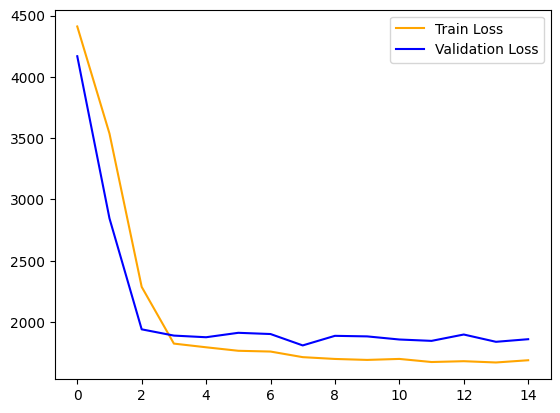

In [40]:
plt.plot(train_losses[:], color = 'orange', label = 'Train Loss')
plt.plot(val_losses[:], color = 'blue', label = 'Validation Loss')
plt.legend()

In [41]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

def experiment(architecture, n_splits = 5):

    kf = KFold(n_splits=n_splits, random_state=22, shuffle=True)
    kf.get_n_splits(data)

    metrics = []

    for train_index, val_index in kf.split(data):

        if architecture == 'cnn':
          model = CNN()
          model.apply(init_weights)
        elif architecture == 'dnn':
          model = DNN()
          model.apply(init_weights)

        test_index = val_index[len(val_index)//2:]
        val_index = val_index[:len(val_index)//2]
        

        X_train = data.iloc[train_index].drop('target',axis=1)
        X_val = data.iloc[val_index].drop('target',axis=1)
        X_test = data.iloc[test_index].drop('target',axis=1)

        y_train = data.iloc[train_index]['target']
        y_val = data.iloc[val_index]['target']
        y_test = data.iloc[test_index]['target']



        train_set = MyDataset(X_train.values,y_train.values)
        val_set = MyDataset(X_val.values,y_val.values)
        test_set = MyDataset(X_test.values,y_test.values)

        training_loader = DataLoader(train_set,batch_size = 512)
        validation_loader = DataLoader(val_set,batch_size = 512)
        testing_loader = DataLoader(test_set,batch_size = 512)
        


        val_loss = torch.nn.MSELoss()
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)#,weight_decay = 0.000001)


        train_losses = []
        val_losses = [] 
        best_model = train_regression_model(model, loss_fn, val_loss, optimizer, training_loader, validation_loader, num_epochs=60, patiance = 15)


        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        preds = []
        for X, feat, y in testing_loader:
          predictions = best_model(X.to(device), feat.to(device))
          predictions = predictions
          for pred in predictions:
            preds.append(pred.item())

        metrics.append(mean_squared_error(preds, y_test, squared = False))
      
    return metrics

In [42]:
metrics = experiment('cnn')

Average training loss for epoch 1: 4515.01062
Average validation loss for epoch 1: 4384.92276
Average training loss for epoch 2: 4186.23402
Average validation loss for epoch 2: 3927.01266
Average training loss for epoch 3: 3616.87722
Average validation loss for epoch 3: 3296.70261
Average training loss for epoch 4: 2948.49047
Average validation loss for epoch 4: 2676.81742
Average training loss for epoch 5: 2364.25364
Average validation loss for epoch 5: 2220.09905
Average training loss for epoch 6: 2012.27615
Average validation loss for epoch 6: 1957.99715
Average training loss for epoch 7: 1827.18306
Average validation loss for epoch 7: 1834.79163
Average training loss for epoch 8: 1747.04789
Average validation loss for epoch 8: 1785.31642
Average training loss for epoch 9: 1731.74612
Average validation loss for epoch 9: 1829.71311
Average training loss for epoch 10: 1739.76844
Average validation loss for epoch 10: 1822.06767
Average training loss for epoch 11: 1721.38585
Average val

In [43]:
print("MEAN RMSE FOR X", np.array(metrics).mean())
print("STD OF RMSE FOR X", np.array(metrics).std(ddof = 1))

MEAN RMSE FOR X 1691.2979490644248
STD OF RMSE FOR X 96.41208964856253


In [44]:
import xgboost as xgb
from sklearn.model_selection import KFold

def get_xgb_model(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    kf.get_n_splits(X)

    predict_train = np.zeros(len(X))

    for train_index, val_index in kf.split(X):

        model = xgb.XGBRegressor(
                                 n_estimators=250,
                                 random_state=42,
                                 verbosity = 0)

        model.fit(X[train_index], y[train_index])

        predict_train[val_index] = model.predict(X[val_index])

    return predict_train

In [46]:
pred_xgb = get_xgb_model(data.drop('target',axis=1).values,data['target'].values)

In [47]:
def get_rmse_metric(x, y, folds=5):
    if x.shape != y.shape:
        print('x.shape != y.shape')
        raise

    splits = np.array_split(np.arange(len(x)), folds)

    rmse = []
    for split in splits:
        rmse.append(get_rmse(x[split], y[split]))

    return np.nanmean(rmse), np.nanstd(rmse)

(1814.1291115140677, 144.74346796998785)

In [61]:
print("MEAN RMSE FOR X: {} \nSTD OF RMSE FOR X: {}".format(*get_rmse_metric(pred_xgb,data['target'].values)))

MEAN RMSE FOR X: 1814.1291115140677 
STD OF RMSE FOR X: 144.74346796998785


In [62]:
real = []
preds = []
for X,feat, y in validation_loader:
  predictions = best_model(X.to('cuda'),feat.to('cuda'))
  for pred in predictions:
    preds.append(pred.item())
  for tar in y:
    real.append(tar.item())

In [63]:
real = np.array(real)
preds = np.array(preds)


In [64]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(preds,real,squared=False)
print('{:f}'.format(mse))

1868.601193


In [65]:
tar_real = [[real[i],(real[i]-preds[i])**2] for i in range(len( real))]
tar_real = np.array(tar_real)
tar_real = tar_real[tar_real[:, 0].argsort()]
bins=np.linspace(0, 20000,10,endpoint = False)

bins_str = ['0-2k', '2k-4k','4k-6k','6k-8k','8k-10k','10k-12k','12k-14k','14k-16k','16k-18k','>18k']

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(1, 0, '2k-4k'),
  Text(2, 0, '4k-6k'),
  Text(3, 0, '6k-8k'),
  Text(4, 0, '8k-10k'),
  Text(5, 0, '10k-12k'),
  Text(6, 0, '12k-14k'),
  Text(7, 0, '14k-16k'),
  Text(8, 0, '16k-18k'),
  Text(9, 0, '>18k')])

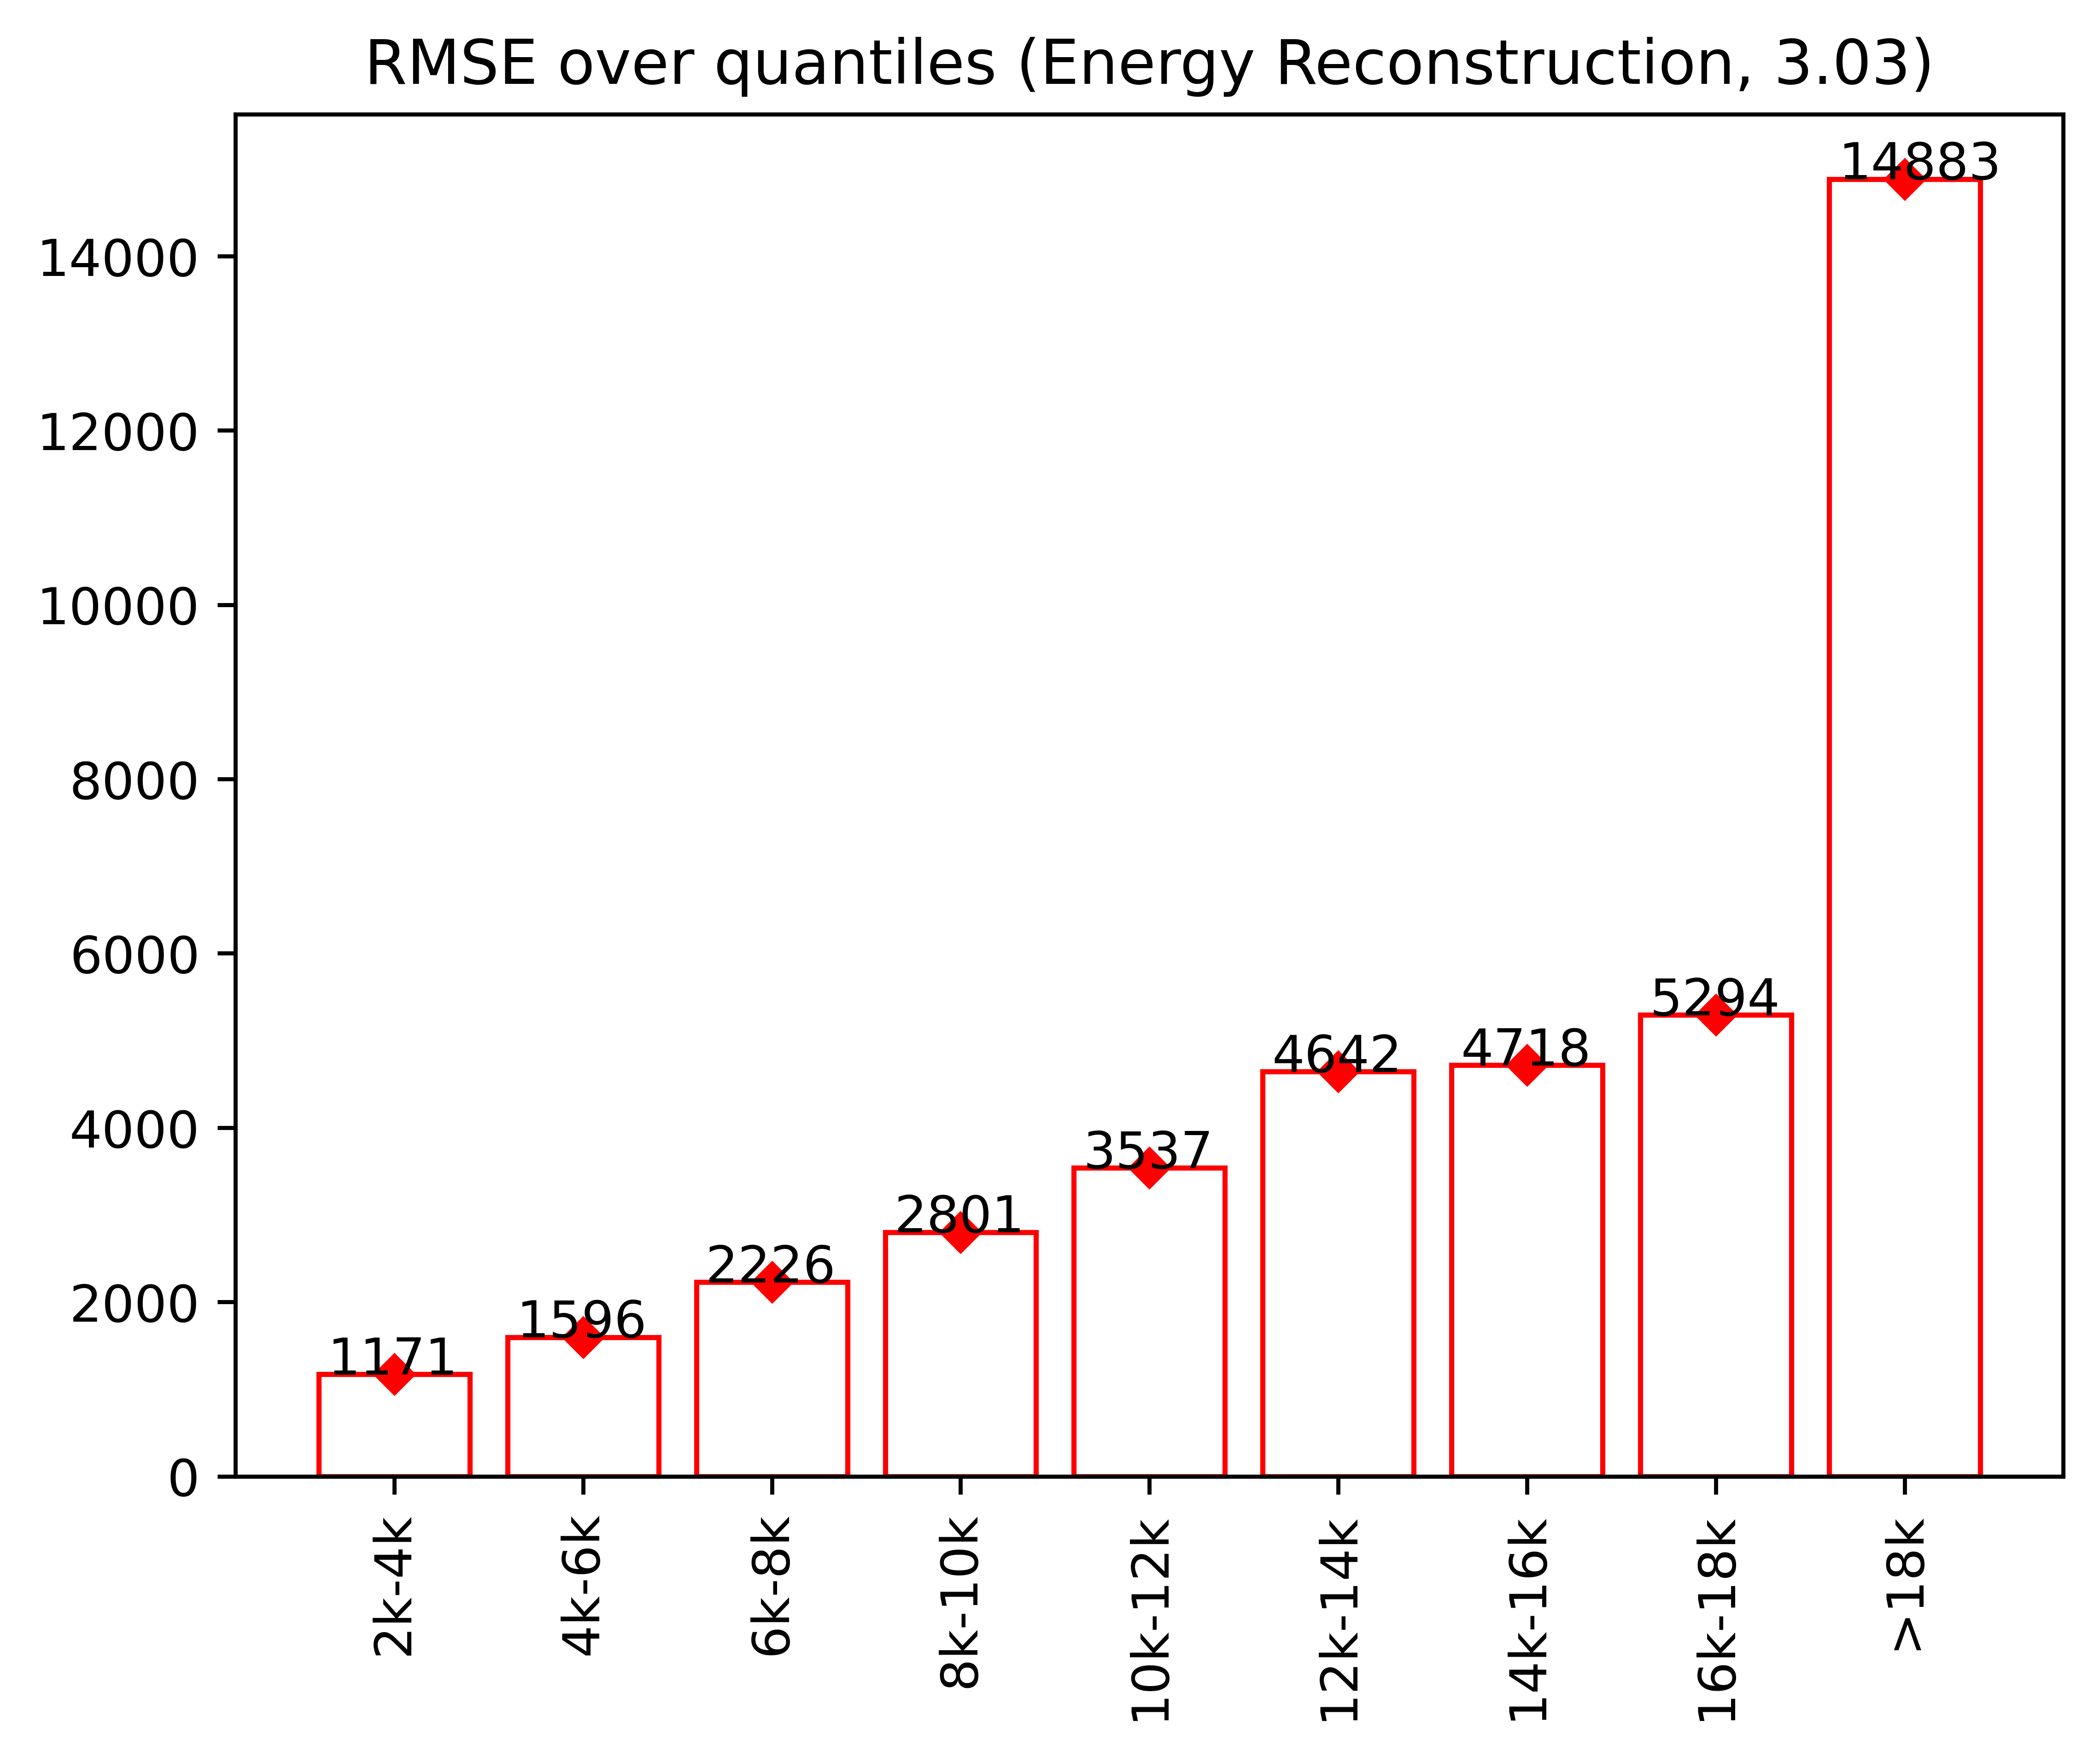

In [66]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 800
bins = np.linspace(0, 20000,10,endpoint = False)
bin_index = np.digitize(tar_real[:,0], bins=bins)
bin_medians= [np.sqrt(np.mean(tar_real[:,1][bin_index == i])) for i in range(2,11)]
plt.title('RMSE over quantiles (Energy Reconstruction, 3.03)')
plt.bar(range(1,10), bin_medians, tick_label =bins_str[1:], color = 'white', edgecolor = 'red')
        #width = 0.5)

for i, v in enumerate(bins_str[1:]):
    plt.text(i+0.65,bin_medians[i] + 0.1, int(bin_medians[i]))
for i, v in enumerate(bins_str[1:]):
    plt.plot(i+1,bin_medians[i], marker='D', ls='none', ms=5, color = 'red')
    #plt.text(i+0.65,bin_medians[i] + 0.1, )
#plt.errorbar(range(1,10), bin_medians, fmt='o', c='C03', alpha=0.7, label='Current reconstruction', tick_label =bins_str[1:])

plt.xticks(rotation=90)

In [67]:
import xgboost as xgb 

X_train,X_val,y_train,y_val = train_test_split(data.drop('target',axis=1), 
                                               data.target, random_state=42, shuffle=True)
baseline = xgb.XGBRegressor(n_estimators=250,
                         random_state=42,
                         verbosity = 1)

baseline.fit(X_train, y_train)

preds = baseline.predict(X_val)

from sklearn.metrics import mean_squared_error
mean_squared_error(preds, y_val, squared=False)

1925.7690759535326

In [68]:
preds_bs = baseline.predict(X_val)

In [69]:
tar_real_xb = [[y_val.values[i],(y_val.values[i]-preds_bs[i])**2] for i in range(len(y_val))]

In [70]:
tar_real_xb = np.array(tar_real_xb)
tar_real_xb = tar_real_xb[tar_real_xb[:, 0].argsort()]

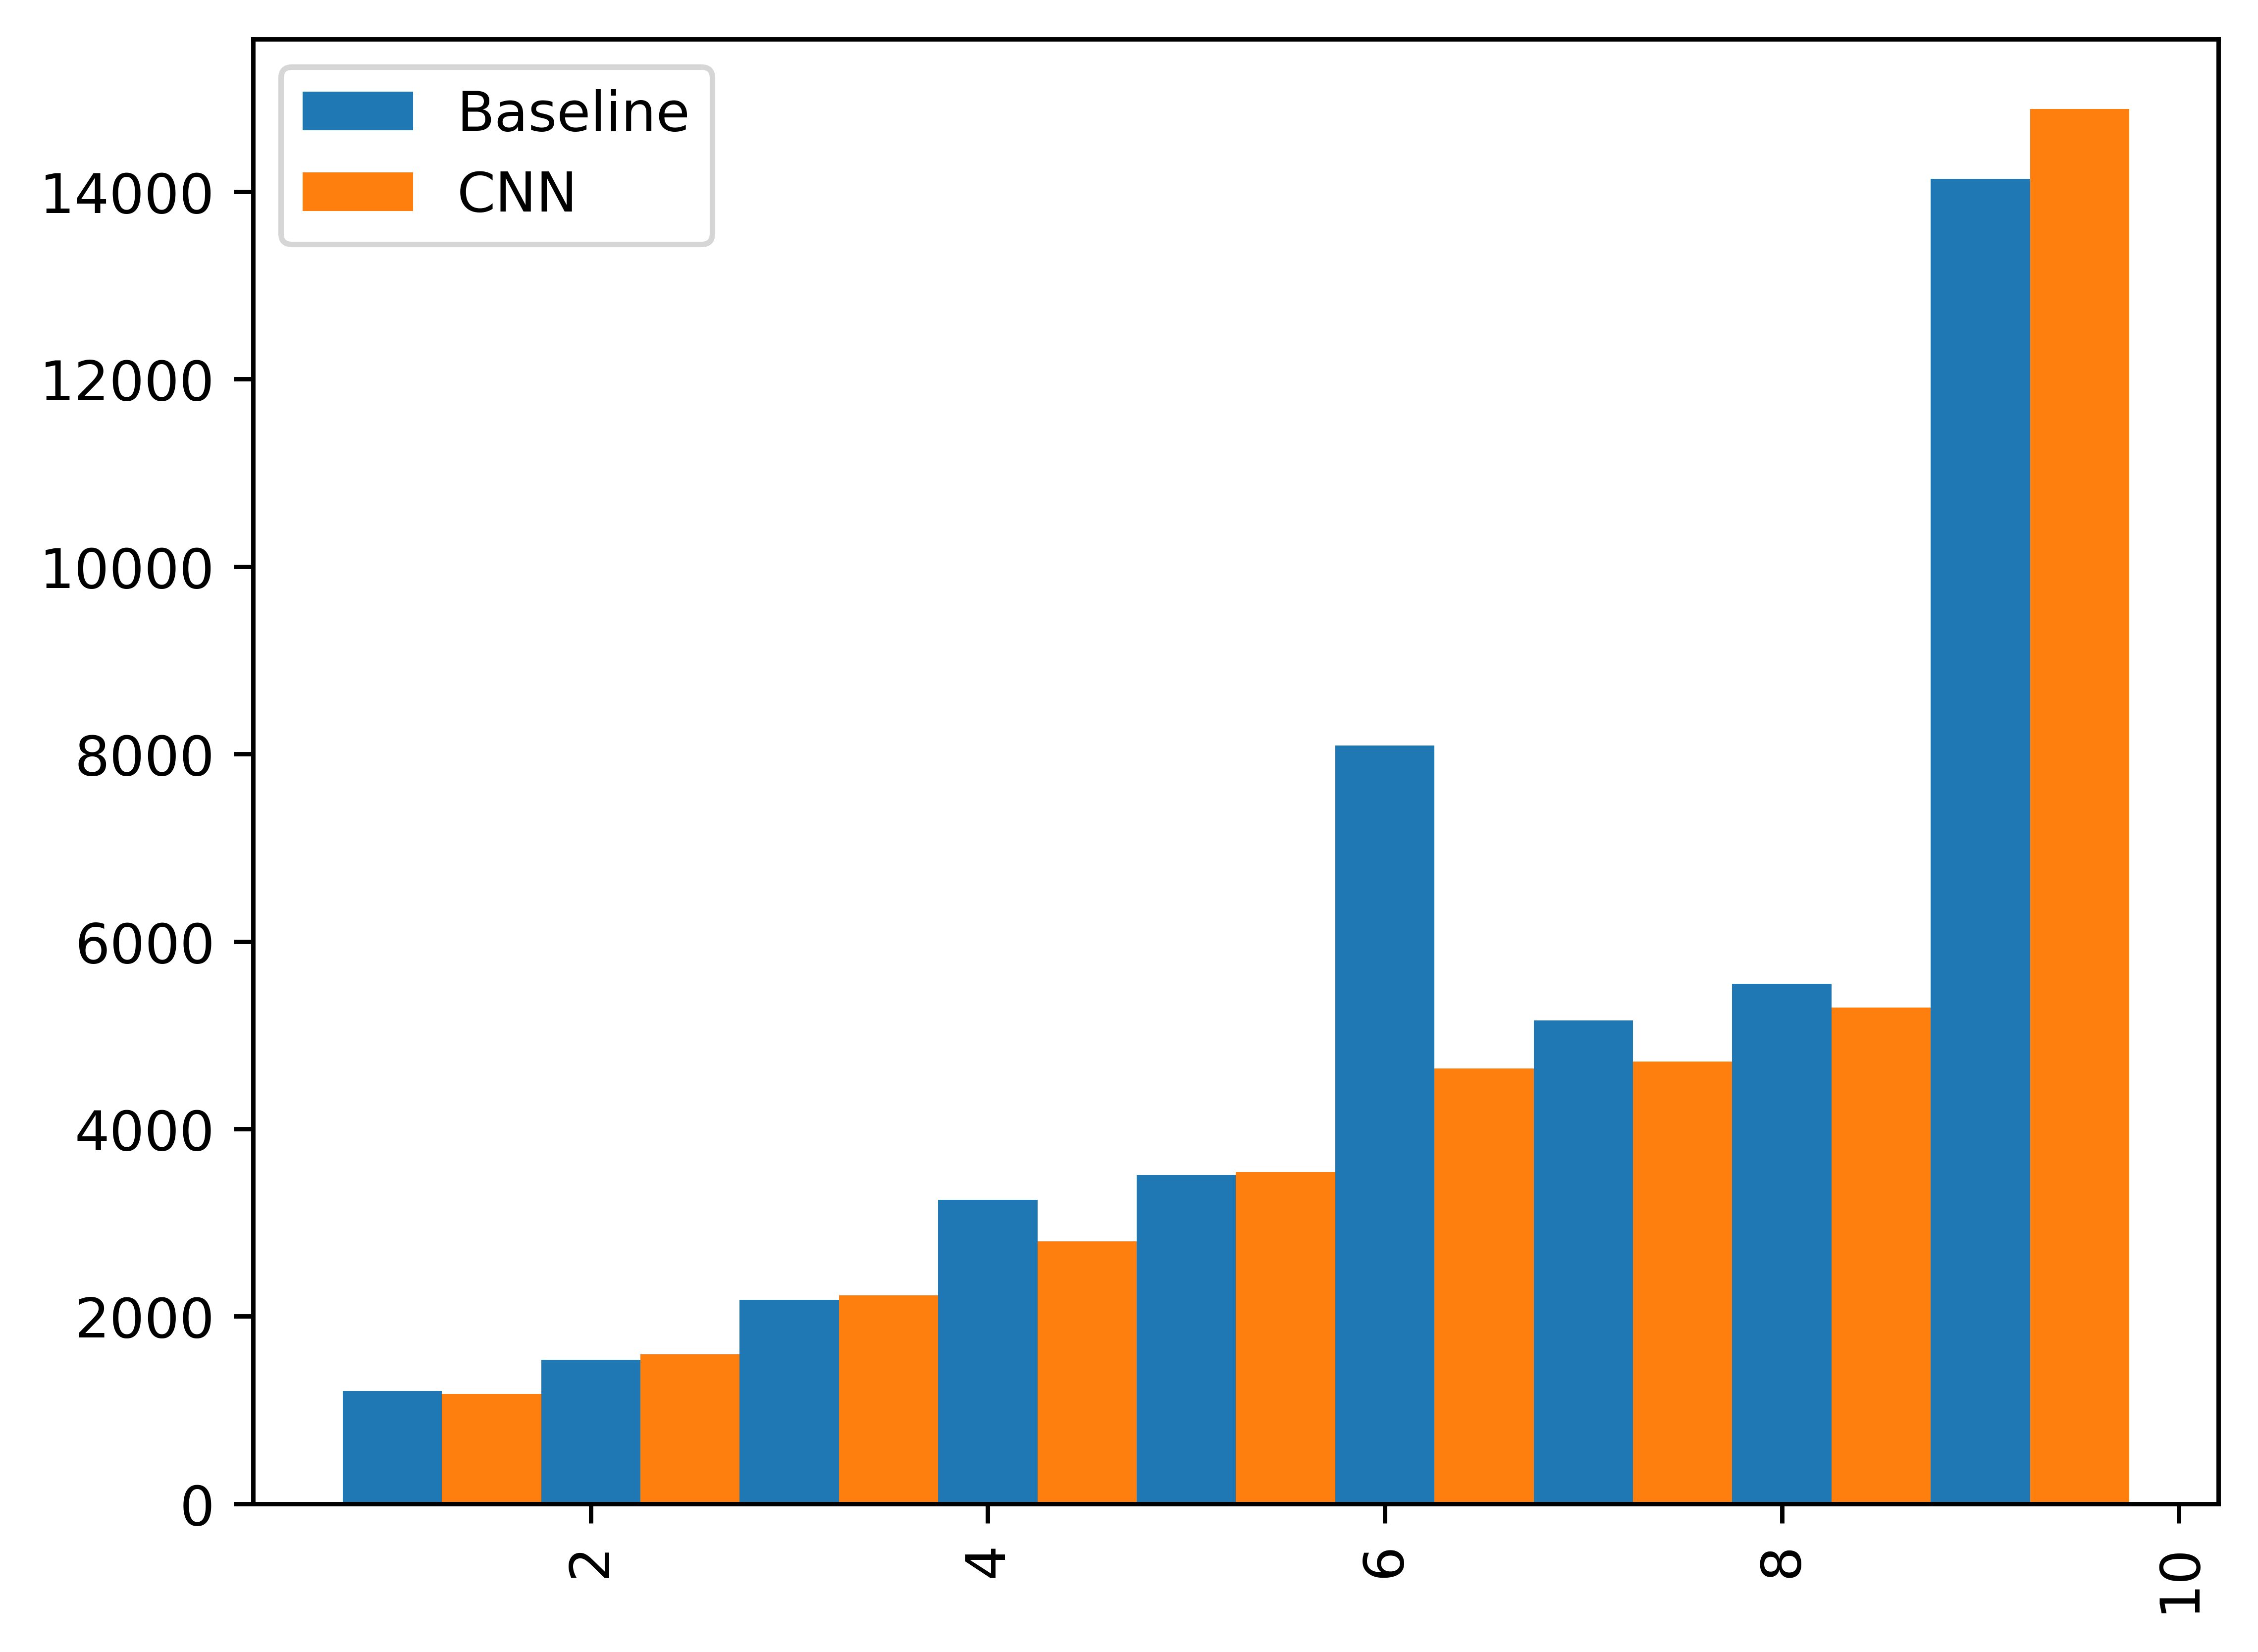

In [71]:
bin_index_xb = np.digitize(tar_real_xb[:,0], bins=np.linspace(0, 20000,10,endpoint = False))
bin_medians_xb= [np.sqrt(np.mean(tar_real_xb[:,1][bin_index_xb == i])) for i in range(2,11)]
plt.bar(range(1,10), bin_medians_xb, #tick_label =bins_str[1:], 
        width = 0.5,label = 'Baseline')
plt.bar(np.array(range(1,10))+0.5, bin_medians, #tick_label =bins_str[1:], 
        width = 0.5, label = 'CNN')
plt.xticks(rotation=90)
plt.legend()